In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Rescaling,
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import torch

2024-11-12 11:15:05.276639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 11:15:05.286483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 11:15:05.297666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 11:15:05.300994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 11:15:05.309688: I tensorflow/core/platform/cpu_feature_guar

In [4]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [13]:
path = "/media/guimcc/Elements/data_2"

# Load sales data
train_df = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [7]:
train_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'external_code', 'season', 'category', 'release_date', 'day', 'week',
       'month', 'year', 'image_path', 'color', 'fabric', 'extra'],
      dtype='object')

In [8]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,external_code,day,week,month,year
count,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000
mean,0.014884,0.051102,0.058264,0.056137,0.054268,0.053161,0.050315,0.046183,0.041616,0.037107,0.030973,0.027149,2540.500000,0.526575,0.499440,0.535105,0.999445
std,0.023272,0.050550,0.052228,0.050573,0.050793,0.054166,0.056004,0.057796,0.055524,0.055351,0.048515,0.048246,1466.614014,0.284090,0.282472,0.281798,0.000409
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,0.000000,0.000000,0.000000,-0.001878,-0.000939,0.000000,1.000000,0.000000,0.019231,0.083333,0.998514
25%,0.002817,0.017840,0.022535,0.021596,0.021596,0.019718,0.018779,0.015962,0.012207,0.009390,0.006573,0.004695,1270.750000,0.333333,0.230769,0.250000,0.999009
50%,0.006573,0.037559,0.044131,0.044131,0.041315,0.037559,0.033803,0.030047,0.025352,0.021596,0.016901,0.014085,2540.500000,0.500000,0.538462,0.583333,0.999505
75%,0.017840,0.066667,0.079812,0.074178,0.069484,0.067606,0.061033,0.053521,0.047887,0.043192,0.036620,0.030986,3810.250000,0.666667,0.730769,0.750000,1.000000
max,0.512676,0.763380,0.460094,0.596244,0.628169,0.739906,0.684507,0.998122,0.615962,1.000000,0.921127,0.905164,5080.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
train_df['extra']

0              hem
1              hem
2              hem
3       sleeveless
4              hem
           ...    
5075     racerback
5076        zipper
5077        sleeve
5078           hem
5079           hem
Name: extra, Length: 5080, dtype: object

In [17]:
# Extract image paths and numerical values 
image_paths_train = train_df['image_path'].tolist()
numerical_values_train = train_df[[str(i) for i in range(12)]].astype('float32')

image_paths_test = test_df['image_path'].tolist()
numerical_values_test = test_df[[str(i) for i in range(12)]].astype('float32')

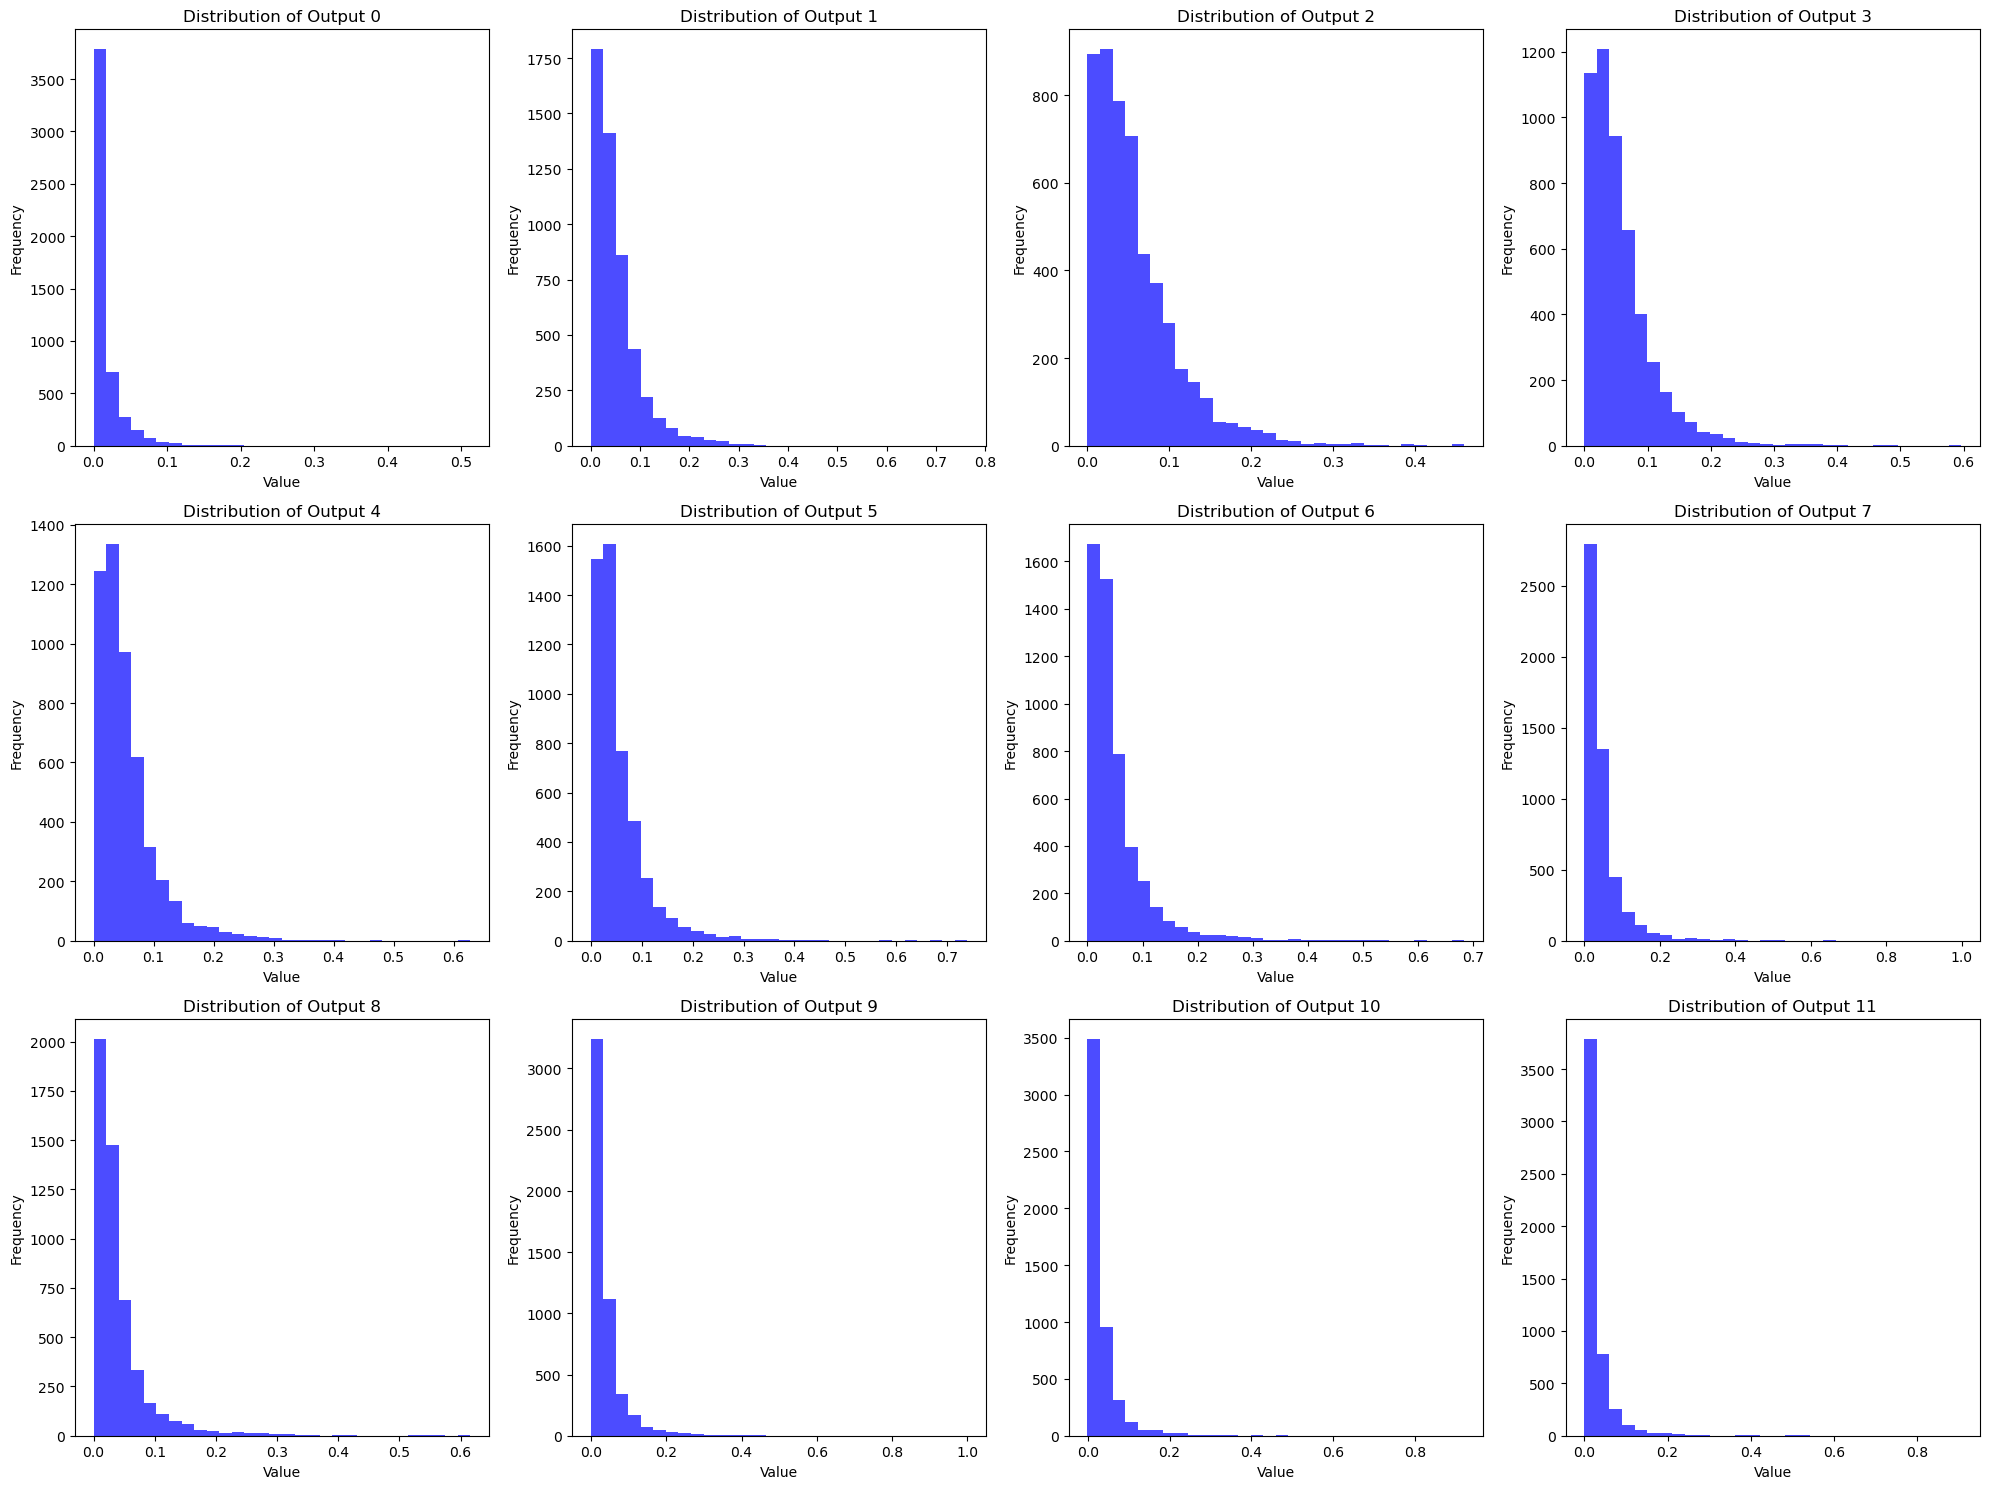

In [18]:
# Plot the distribution of each of the 12 outputs
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i in range(12):
    axes[i].hist(numerical_values_train.iloc[:, i], bins=30, alpha=0.7, color='blue')
    axes[i].set_title(f'Distribution of Output {i}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Feature extraction de la **SUMA** d'aquests valors per a treure una "aggregació" total.

In [19]:
y_train_sum = np.sum(numerical_values_train, axis=1)
y_test_sum = np.sum(numerical_values_test, axis=1)

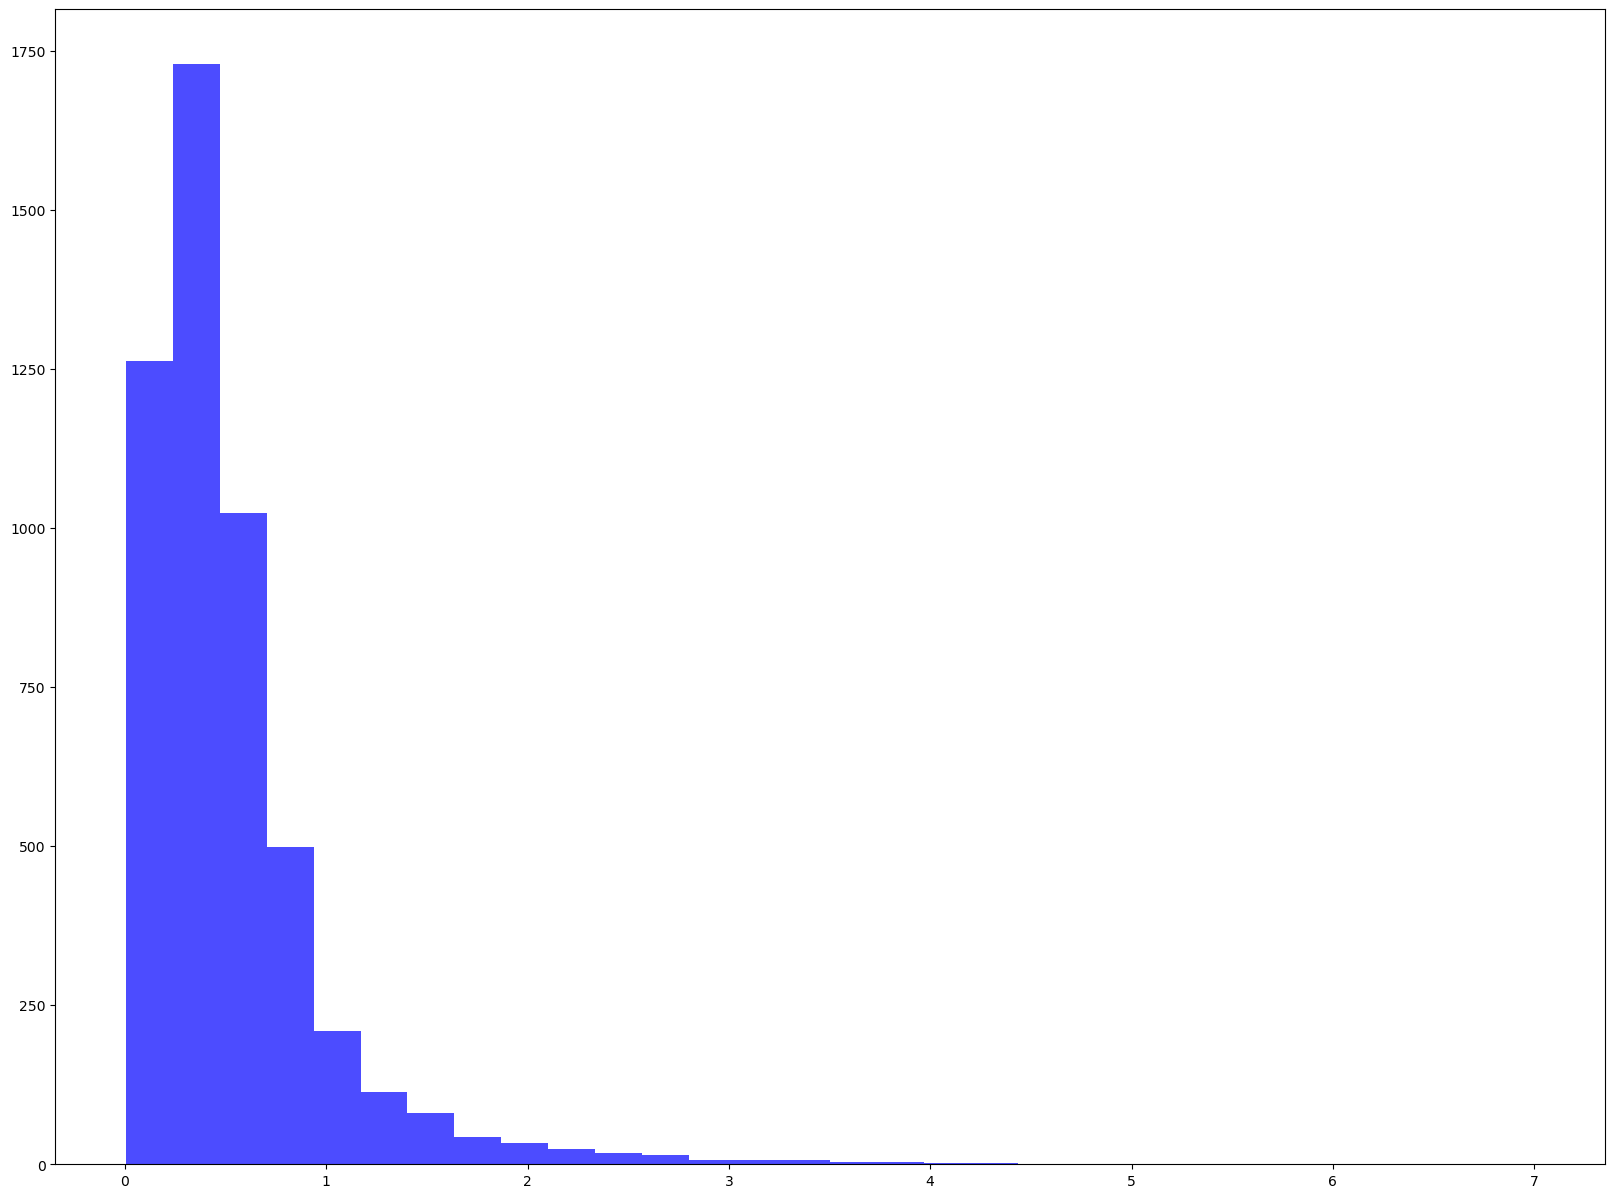

In [20]:
plt.figure(figsize=(20, 15))
plt.hist(y_train_sum, bins=30, alpha=0.7, color='blue')
plt.show()

In [11]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52)
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len]
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten()
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

In [9]:
from pathlib import Path

 # Load category and color encodings
cat_dict = torch.load(Path(path + '/category_labels.pt'))
col_dict = torch.load(Path(path + '/color_labels.pt'))
fab_dict = torch.load(Path(path + '/fabric_labels.pt'))

gtrends = pd.read_csv(Path(path + '/gtrends.csv'), index_col=[0], parse_dates=True)


/tmp/ipykernel_26062/294751658.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cat_dict = torch.load(Path(path + '/category_labels.pt'))
/tmp/ipykernel_26062/294751658.p

In [15]:
train_loader = ZeroShotDataset(train_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                   fab_dict, 52).get_loader(batch_size=32, train=True)
test_loader = ZeroShotDataset(test_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                  fab_dict, 52).get_loader(batch_size=1, train=False)

Starting dataset creation process...


100%|##########| 5080/5080 [01:25<00:00, 59.10it/s] 


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:09<00:00, 51.79it/s]


Done.


In [18]:
# Extract the data from the DataLoader for EDA
item_sales_list, categories_list, colors_list, fabrics_list, temporal_features_list, gtrends_list, images_list = [], [], [], [], [], [], []

for item_sales, categories, colors, fabrics, temporal_features, gtrends, images in train_loader:
    item_sales_list.append(item_sales.numpy())
    categories_list.append(categories.numpy())
    colors_list.append(colors.numpy())
    fabrics_list.append(fabrics.numpy())
    temporal_features_list.append(temporal_features.numpy())
    gtrends_list.append(gtrends.numpy())
    images_list.append(images.numpy())

# Convert lists to arrays for analysis
item_sales = np.concatenate(item_sales_list)
categories = np.concatenate(categories_list)
colors = np.concatenate(colors_list)
fabrics = np.concatenate(fabrics_list)
temporal_features = np.concatenate(temporal_features_list)
gtrends = np.concatenate(gtrends_list)

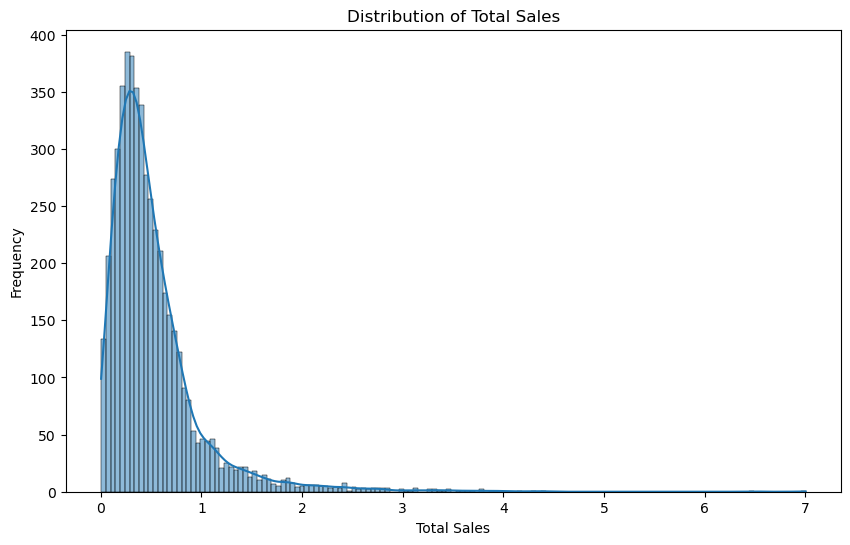

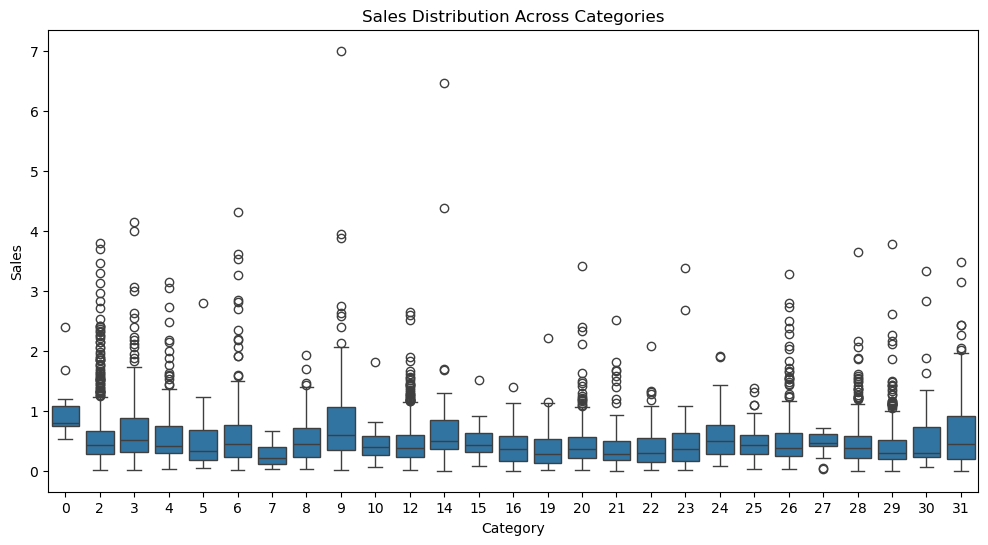

In [19]:
import seaborn as sns

# Plot the distribution of total sales across all items
total_sales = item_sales.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(total_sales, kde=True)
plt.title("Distribution of Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Frequency")
plt.show()

# Compare sales across categories
sales_by_category = pd.DataFrame({"Sales": total_sales, "Category": categories})
plt.figure(figsize=(12, 6))
sns.boxplot(x="Category", y="Sales", data=sales_by_category)
plt.title("Sales Distribution Across Categories")
plt.show()

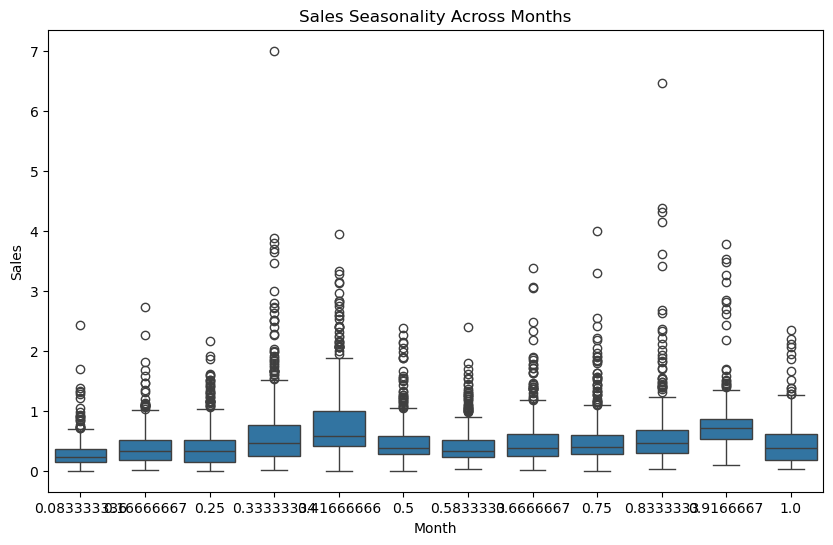

In [20]:
# Example: Temporal feature analysis
temporal_features_df = pd.DataFrame(temporal_features, columns=["Day", "Week", "Month", "Year"])

# Plot sales by month to see seasonality
sales_by_month = pd.DataFrame({"Sales": total_sales, "Month": temporal_features_df["Month"]})
plt.figure(figsize=(10, 6))
sns.boxplot(x="Month", y="Sales", data=sales_by_month)
plt.title("Sales Seasonality Across Months")
plt.show()

## Models

### First CNN

In [34]:
img_width, img_height = 224, 224

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    try:
        img = load_img(f'/media/guimcc/Elements/data_2/images/{image_path}', target_size=(img_width, img_height))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        return img_array
    except Exception as e:
        # If there's an error loading the image, return an array of zeros
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((img_height, img_width, 3))

# # Load and preprocess images
# images_train = np.array([load_and_preprocess_image(path) for path in image_paths_train])
# images_test = np.array([load_and_preprocess_image(path) for path in image_paths_test])

In [21]:
import tensorflow as tf
img_width, img_height = 224, 224

# Function to load and preprocess images
def preprocess_image(image_path):
    img = load_img(f"/media/guimcc/Elements/data_2/images/{image_path.decode('utf-8')}", target_size=(img_width, img_height))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

def load_and_preprocess_image(image_path, label):
    image = tf.numpy_function(preprocess_image, [image_path], tf.float32)
    image.set_shape((img_height, img_width, 3))
    return image, label

# Create a TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, y_train_sum))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create a TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, y_test_sum))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1731401525.679349    7268 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731401525.772895    7268 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731401525.773463    7268 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731401525.776950    7268 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [42]:
# Define the CNN model
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1BN = BatchNormalization()(c1)
c1MP = MaxPooling2D((2, 2))(c1BN)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1MP)
c2BN = BatchNormalization()(c2)
c2MP = MaxPooling2D((2, 2))(c2BN)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
c3BN = BatchNormalization()(c3)
c3MP = MaxPooling2D((2, 2))(c3BN)

# Fourth Convolutional Block
c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c3MP)
c4BN = BatchNormalization()(c4)
c4MP = MaxPooling2D(pool_size=(2, 2))(c4BN)
c4DP = Dropout(0.5)(c4MP)

# Flatten and Fully Connected Layers
o1F = Flatten()(c4DP)
o1DE1 = Dense(512, activation='relu')(o1F)
o1DP = Dropout(0.5)(o1DE1)
o1DE2 = Dense(256, activation='relu')(o1DP)

# Output Layer
outputs = Dense(1, activation='linear')(o1DE2)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,198,849 (199.12 MB)

 Trainable params: 52,197,377 (199.12 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [59]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [60]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    batch_size=32,
    validation_data=test_dataset,
    callbacks=[lr_scheduler]
)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - loss: 0.1943 - mae: 0.2935 - val_loss: 0.2137 - val_mae: 0.2452 - learning_rate: 1.0000e-04
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 0.1855 - mae: 0.2920 - val_loss: 0.2087 - val_mae: 0.2449 - learning_rate: 1.0000e-04
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - loss: 0.1871 - mae: 0.2915 - val_loss: 0.2102 - val_mae: 0.2483 - learning_rate: 1.0000e-04
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 0.1936 - mae: 0.2909 - val_loss: 0.2158 - val_mae: 0.2473 - learning_rate: 1.0000e-04
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.1834 - mae: 0.2883 - val_loss: 0.2111 - val_mae: 0.2449 - learning_rate: 1.0000e-04
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.1853 - mae: 0.2915 - val_loss: 0.2075 - val_mae: 0.2436 - learning_rate: 1.0000e-04
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.1835 - mae: 0.2902 - val_loss: 0.2128 - v

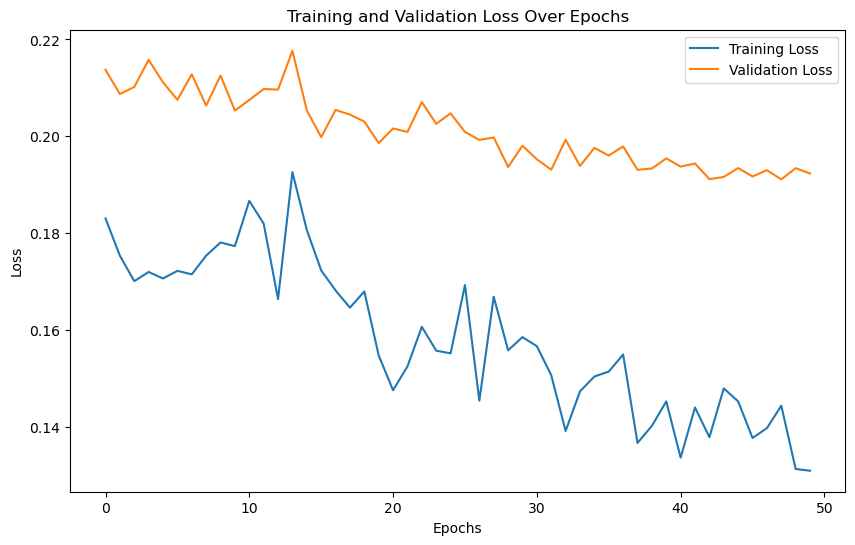

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [62]:
model.save('model_50_2.keras')

In [63]:
# Evaluate the model on the test dataset
loss, mae = model.evaluate(test_dataset)
print(f"Test Loss (MSE): {loss}")
print(f"Test Mean Absolute Error (MAE): {mae}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2551 - mae: 0.2756
Test Loss (MSE): 0.19230546057224274
Test Mean Absolute Error (MAE): 0.2408631443977356


In [64]:
y_pred = model.predict(test_dataset)
print(y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
[[0.69357896]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.62992734]
 [0.67423046]
 [0.44822735]
 [0.5351826 ]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.7552175 ]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.84145224]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.54203784]
 [0.45669934]
 [0.59692997]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.5019207 ]
 [0.45669934]
 [0.45669934]
 [0.6952655 ]
 [0.45669934]
 [0.45669934]
 [0.50667614]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.72261536]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.45669934]
 [0.4745417 ]
 [0.45669934]
 [0.45669934]
 [0.4566

In [51]:
from sklearn.metrics import r2_score

# Compute R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2}")


NameError: name 'y_test' is not defined

In [ ]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

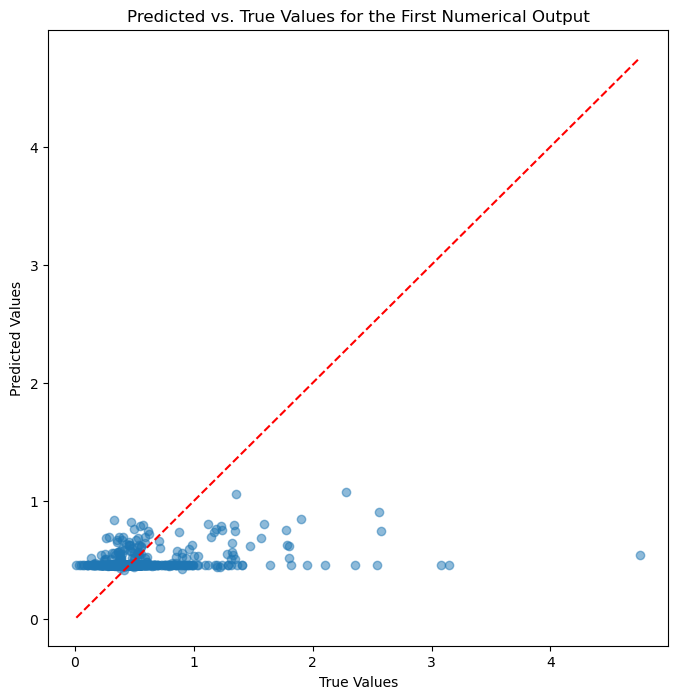

In [65]:

# Plot the first numerical value as an example
plt.figure(figsize=(8, 8))
plt.scatter(y_test_sum, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the First Numerical Output")
plt.plot([min(y_test_sum), max(y_test_sum)],
         [min(y_test_sum), max(y_test_sum)], 'r--')  # Line y = x
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

simple_model = Sequential([
    Flatten(input_shape=(img_height, img_width, 3)),
    Dense(128, activation='relu'),
    Dense(12, activation='linear')
])

simple_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
simple_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
y_pred_simple = simple_model.predict(X_test)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load VGG16 without the top layer (output layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(12, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the ResNet50 model with pre-trained ImageNet weights, without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use global average pooling to reduce the feature map size
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)  # Single output for regression

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

In [25]:
# Unfreeze some layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze the first few layers
    layer.trainable = False

# Re-compile the model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# Train again for fine-tuning
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    batch_size=32
)


Epoch 1/10


I0000 00:00:1731401587.597268   13694 service.cc:146] XLA service 0x759d7c011df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731401587.597300   13694 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-11-12 09:53:07.866580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 09:53:08.841385: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-12 09:53:10.014712: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11649', 32 bytes spill stores, 32 bytes spill loads

2024-11-12 09:53:10.179723: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memo

158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.5443 - mae: 0.5433

2024-11-12 09:53:37.166109: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8522', 12 bytes spill stores, 12 bytes spill loads

2024-11-12 09:53:37.522160: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8522', 12 bytes spill stores, 12 bytes spill loads

2024-11-12 09:53:37.722736: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7358', 176 bytes spill stores, 176 bytes spill loads

2024-11-12 09:53:37.752723: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7358', 12 bytes spill stores, 12 bytes spill loads

2024-11-12 09:53:38.116280: I external/local_xla/xla/strea

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.5436 - mae: 0.5428

2024-11-12 09:53:51.096564: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1691', 176 bytes spill stores, 176 bytes spill loads

2024-11-12 09:53:51.382522: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1691', 12 bytes spill stores, 12 bytes spill loads



159/159 ━━━━━━━━━━━━━━━━━━━━ 52s 219ms/step - loss: 0.5430 - mae: 0.5424 - val_loss: 0.2970 - val_mae: 0.3385
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 0.2877 - mae: 0.3682 - val_loss: 0.2654 - val_mae: 0.2994
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 0.2683 - mae: 0.3404 - val_loss: 0.2551 - val_mae: 0.2926
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - loss: 0.2563 - mae: 0.3299 - val_loss: 0.2554 - val_mae: 0.2901
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - loss: 0.2419 - mae: 0.3225 - val_loss: 0.2459 - val_mae: 0.2809
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 0.2317 - mae: 0.3177 - val_loss: 0.2507 - val_mae: 0.2847
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - loss: 0.2230 - mae: 0.3111 - val_loss: 0.2399 - val_mae: 0.2771
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - loss: 0.2150 - mae: 0.3081 - val_loss: 0.2371 - val_mae: 0.2796
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s

In [ ]:
y_pred_2 = model.predict(test_dataset)
print(y_pred_2)

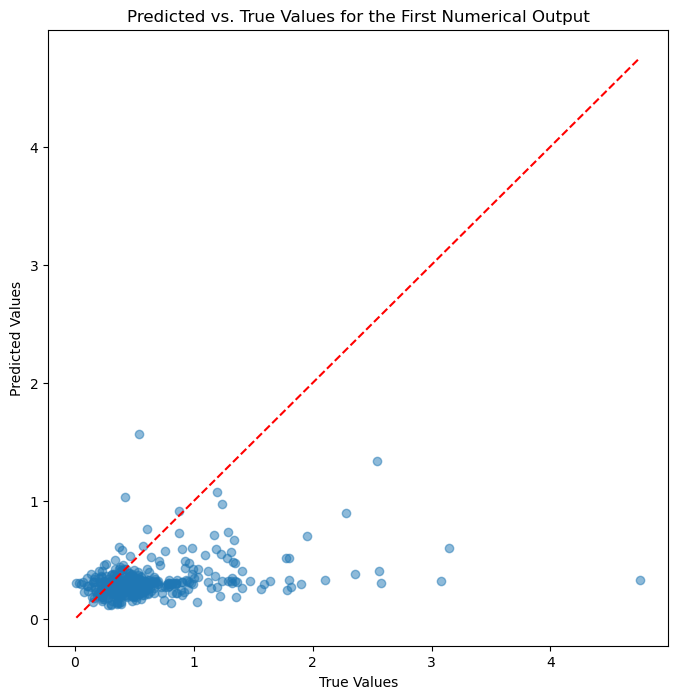

In [27]:
# Plot the first numerical value as an example
plt.figure(figsize=(8, 8))
plt.scatter(y_test_sum, y_pred_2, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the First Numerical Output")
plt.plot([min(y_test_sum), max(y_test_sum)],
         [min(y_test_sum), max(y_test_sum)], 'r--')  # Line y = x
plt.show()

### Bag of Visual words

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [47]:
from tqdm import tqdm

sift = cv2.SIFT_create()

# Function to extract SIFT features from an image
def extract_sift_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize image to a fixed size
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

# Example usage
descriptors_list = []
keypoints_list = []
for image_path in tqdm(image_paths_train):
    keypoints, descriptors = extract_sift_features(f'/media/guimcc/Elements/data_2/images/{image_path}')
    
    # Check if descriptors are not None
    if descriptors is not None:    
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
    

100%|██████████| 5080/5080 [01:22<00:00, 61.60it/s]


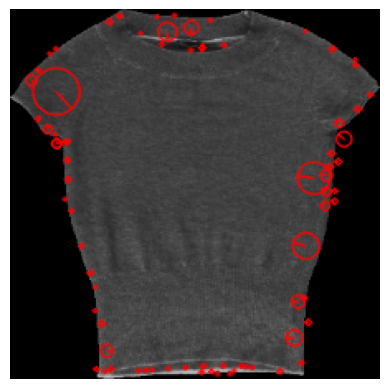

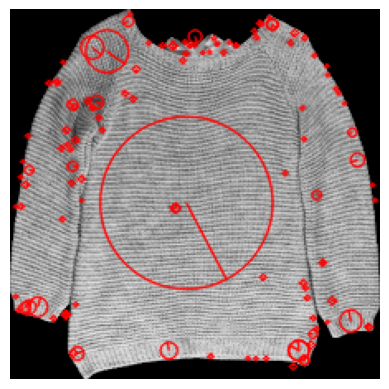

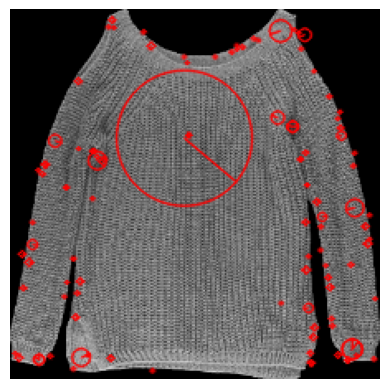

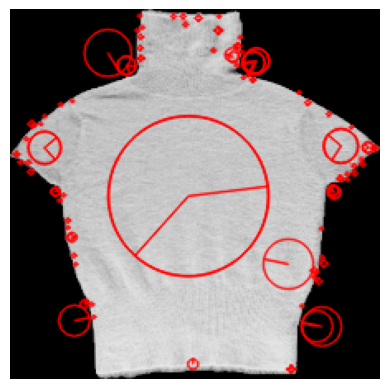

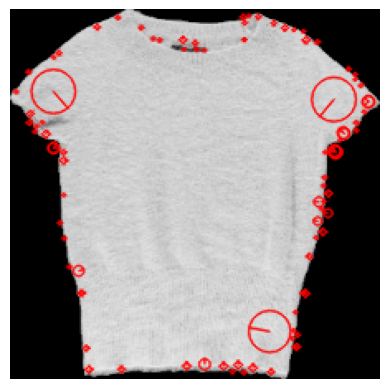

In [49]:
for x in range(10,15):
    # Load the image from the path
    image_path = f'/media/guimcc/Elements/data_2/images/{image_paths_train[x]}'
    image = cv2.imread(image_path)  # Load the image in color (BGR format)
    image = cv2.resize(image, (224, 224))  # Resize the image to a fixed size
    
    # Convert the image to grayscale for keypoint visualization
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Draw keypoints on the grayscale image
    output_image = cv2.drawKeypoints(
        gray_image, keypoints_list[x], None, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Display the image with keypoints using Matplotlib
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

In [71]:
# Stack all descriptors together
all_descriptors = np.vstack(descriptors_list)

# Use K-means to create a visual vocabulary
k = 200  # Number of visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

# Save the cluster centers as the visual vocabulary
visual_words = kmeans.cluster_centers_


In [53]:
visual_words.shape

(100, 128)

In [58]:
# Function to create a histogram of visual words for an image
def create_histogram(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        words = kmeans.predict(descriptors)
        for word in words:
            histogram[word] += 1
    return histogram

# Create histograms for all images
histograms = []
for image_path in tqdm(image_paths_train):
    _, descriptors = extract_sift_features(f'/media/guimcc/Elements/data_2/images/{image_path}')
    histogram = create_histogram(descriptors, visual_words)
    histograms.append(histogram)

# Convert histograms to a NumPy array
X_train_bovw = np.array(histograms)

100%|██████████| 5080/5080 [01:47<00:00, 47.22it/s] 


In [59]:
histograms_test = []
for image_path in tqdm(image_paths_test):
    _, descriptors = extract_sift_features(f'/media/guimcc/Elements/data_2/images/{image_path}')
    histogram = create_histogram(descriptors, visual_words)
    histograms_test.append(histogram)

# Convert histograms to a NumPy array
X_test_bovw = np.array(histograms_test)

100%|██████████| 497/497 [00:08<00:00, 56.16it/s]


In [60]:
X_train, X_test, y_train, y_test = X_train_bovw, X_test_bovw, y_train_sum, y_test_sum

In [61]:
from xgboost import XGBRegressor

# Initialize the XGBoost regressor
model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Learning rate
    max_depth=6,  # Maximum depth of a tree
    random_state=42
)

# Train the model
print("Training the regression model...")
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


Training the regression model...


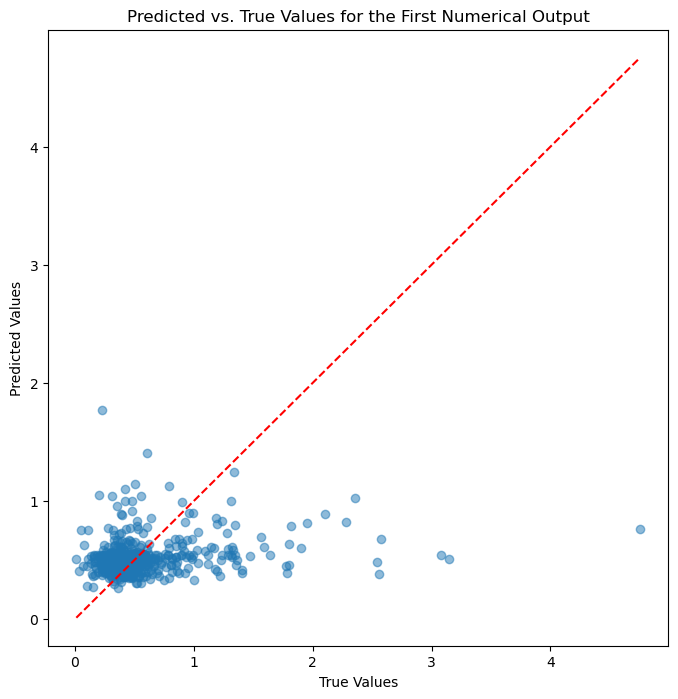

In [63]:
# Plot the first numerical value as an example
plt.figure(figsize=(8, 8))
plt.scatter(y_test_sum, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the First Numerical Output")
plt.plot([min(y_test_sum), max(y_test_sum)],
         [min(y_test_sum), max(y_test_sum)], 'r--')  # Line y = x
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.2022978961467743
Mean Absolute Error (MAE): 0.2593270540237427


In [68]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    n_jobs=-1
)

# Perform grid search
print("Performing grid search...")
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Performing grid search...
Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Best Score: 0.23259523808956145


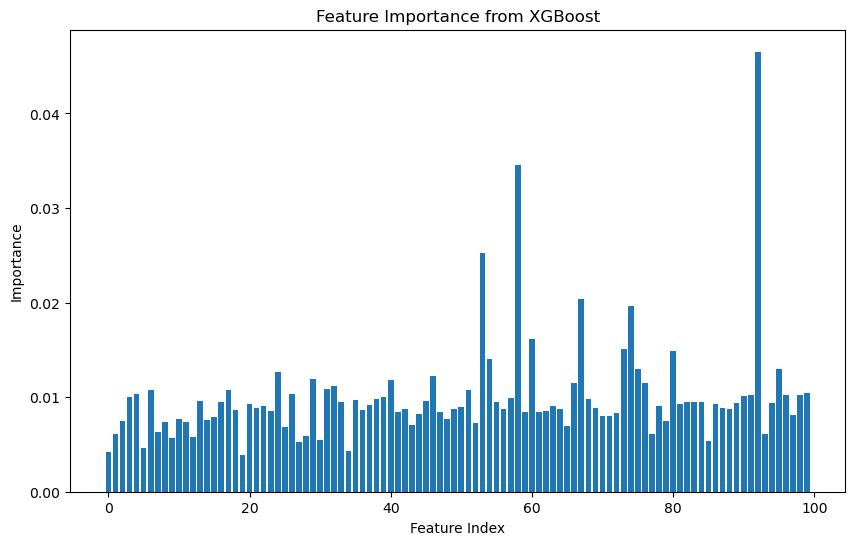

In [69]:
import matplotlib.pyplot as plt

# Plot feature importance
importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from XGBoost")
plt.show()

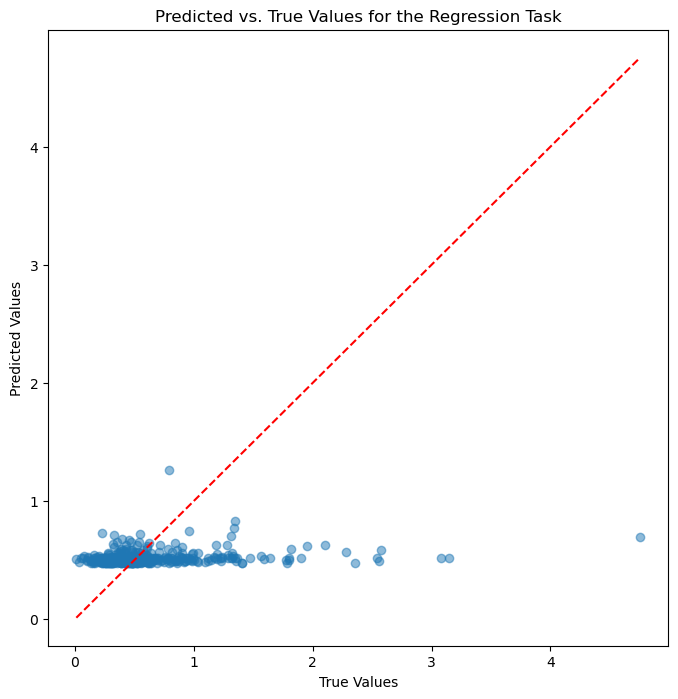

In [70]:
import matplotlib.pyplot as plt

# Get the best model from the Grid Search
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test_bovw)

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_sum, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test_sum), max(y_test_sum)],
         [min(y_test_sum), max(y_test_sum)], 'r--')  # Line y = x for reference
plt.show()
